In [1]:
import pandas as pd

train = pd.read_csv('../Deep-Learning-project/dataset/training.csv')
test = pd.read_csv('../Deep-Learning-project/dataset/test.csv')
validation = pd.read_csv('../Deep-Learning-project/dataset/validation.csv')

In [4]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

nltk.download('stopwords')
nltk.download('punkt')

def preprocess_text(text):
    text = text.lower()  # convert to lowercase
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # remove punctuation
    tokenized = word_tokenize(text)  # tokenize text
    cleaned_text = [word for word in tokenized if word not in stopwords.words('english')]  # remove stopwords
    return " ".join(cleaned_text)

[nltk_data] Downloading package stopwords to C:\Users\ABHISHEK
[nltk_data]     DEORE\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ABHISHEK
[nltk_data]     DEORE\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Assuming the preprocessing function is defined above
train['cleaned_text'] = train['text'].apply(preprocess_text)
test['cleaned_text'] = test['text'].apply(preprocess_text)
validation['cleaned_text'] = validation['text'].apply(preprocess_text)

labels_dict = {0:'sad', 1:'happy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}
train['emotion'] = train['label'].map(labels_dict)
test['emotion'] = test['label'].map(labels_dict)
validation['emotion'] = validation['label'].map(labels_dict)

# Tokenize text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train['cleaned_text'])

X_train = tokenizer.texts_to_sequences(train['cleaned_text'])
X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_val = tokenizer.texts_to_sequences(validation['cleaned_text'])

# Pad sequences
max_length = max(max(len(x) for x in X_train), max(len(x) for x in X_test), max(len(x) for x in X_val))
X_train = pad_sequences(X_train, maxlen=max_length, padding='post')
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')
X_val = pad_sequences(X_val, maxlen=max_length, padding='post')

# Encode labels
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['emotion'])

y_train = encoder.transform(train['emotion'])
y_test = encoder.transform(test['emotion'])
y_val = encoder.transform(validation['emotion'])

In [6]:
test.head(10)

,text,label,cleaned_text,emotion
0,im feeling rather rotten so im not very ambiti...,0,im feeling rather rotten im ambitious right,sad
1,im updating my blog because i feel shitty,0,im updating blog feel shitty,sad
2,i never make her separate from me because i do...,0,never make separate ever want feel like ashamed,sad
3,i left with my bouquet of red and yellow tulip...,1,left bouquet red yellow tulips arm feeling sli...,happy
4,i was feeling a little vain when i did this one,0,feeling little vain one,sad
5,i cant walk into a shop anywhere where i do no...,4,cant walk shop anywhere feel uncomfortable,fear
6,i felt anger when at the end of a telephone call,3,felt anger end telephone call,anger
7,i explain why i clung to a relationship with a...,1,explain clung relationship boy many ways immat...,happy
8,i like to have the same breathless feeling as ...,1,like breathless feeling reader eager see happe...,happy
9,i jest i feel grumpy tired and pre menstrual w...,3,jest feel grumpy tired pre menstrual probably ...,anger


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Parameters (these would need to be adjusted based on your specific dataset)
vocab_size = len(tokenizer.word_index) + 1  # +1 for padding token
embedding_dim = 100  # Size of the embedding vectors
lstm_units = 64  # Number of units in the LSTM layer

In [13]:
# Model definition
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
model.add(LSTM(units=lstm_units, return_sequences=False))
model.add(Dropout(0.5))  # Dropout layer added to prevent overfitting
model.add(Dense(units=encoder.classes_.size, activation='softmax'))  # Assuming a classification problem


In [14]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [15]:
# Summarize the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 35, 100)           1506300   
                                                                 
 lstm_1 (LSTM)               (None, 64)                42240     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 1,548,930
Trainable params: 1,548,930
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [17]:
# Train the model with Early Stopping
history = model.fit(
    X_train, y_train,
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]  # Add early stopping to training
)

Epoch 1/10
500/500 [==============================] - 21s 36ms/step - loss: 1.3826 - accuracy: 0.3773 - val_loss: 1.1571 - val_accuracy: 0.4710
Epoch 2/10
500/500 [==============================] - 17s 33ms/step - loss: 0.9438 - accuracy: 0.5743 - val_loss: 0.7491 - val_accuracy: 0.7190
Epoch 3/10
500/500 [==============================] - 17s 35ms/step - loss: 0.5509 - accuracy: 0.8105 - val_loss: 0.4665 - val_accuracy: 0.8490
Epoch 4/10
500/500 [==============================] - 16s 32ms/step - loss: 0.2887 - accuracy: 0.9093 - val_loss: 0.3429 - val_accuracy: 0.8940
Epoch 5/10
500/500 [==============================] - 16s 33ms/step - loss: 0.1798 - accuracy: 0.9459 - val_loss: 0.3914 - val_accuracy: 0.8845
Epoch 6/10
500/500 [==============================] - 16s 32ms/step - loss: 0.1384 - accuracy: 0.9584 - val_loss: 0.3540 - val_accuracy: 0.9060
Epoch 7/10
500/500 [==============================] - 17s 34ms/step - loss: 0.0992 - accuracy: 0.9707 - val_loss: 0.3750 - val_accuracy:

In [18]:
for epoch, (loss, acc) in enumerate(zip(history.history['loss'], history.history['accuracy'])):
    print(f'Epoch {epoch+1}: Loss = {loss}, Accuracy = {acc}')

Epoch 1: Loss = 1.382603645324707, Accuracy = 0.3773125112056732
Epoch 2: Loss = 0.9437967538833618, Accuracy = 0.5743125081062317
Epoch 3: Loss = 0.5509276390075684, Accuracy = 0.8105000257492065
Epoch 4: Loss = 0.2887480556964874, Accuracy = 0.909250020980835
Epoch 5: Loss = 0.17975912988185883, Accuracy = 0.9459375143051147
Epoch 6: Loss = 0.13838163018226624, Accuracy = 0.9584375023841858
Epoch 7: Loss = 0.09921249747276306, Accuracy = 0.9706875085830688


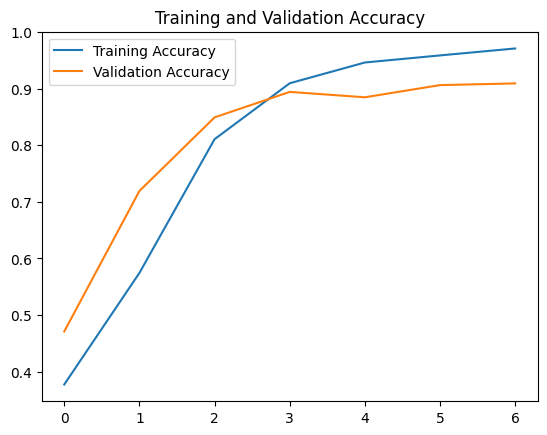

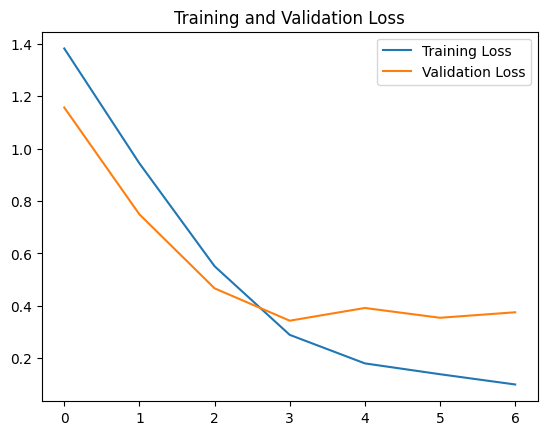

In [19]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Predict probabilities for the validation set
probabilities = model.predict(X_val)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Assuming y_val is already the array of labels and not one-hot encoded
print("Accuracy for Validation Data - ",accuracy_score(y_val, predictions)*100)
print(classification_report(y_val, predictions))


63/63 [==============================] - 0s 5ms/step
Accuracy for Validation Data -  90.9
              precision    recall  f1-score   support

           0       0.87      0.93      0.90       275
           1       0.93      0.80      0.86       212
           2       0.94      0.93      0.94       704
           3       0.84      0.77      0.80       178
           4       0.93      0.96      0.95       550
           5       0.73      0.89      0.80        81

    accuracy                           0.91      2000
   macro avg       0.87      0.88      0.87      2000
weighted avg       0.91      0.91      0.91      2000



In [25]:
# Tokenize the test text data
X_test = tokenizer.texts_to_sequences(test['cleaned_text'])
X_test = pad_sequences(X_test, maxlen=max_length, padding='post')

# Encode the labels if they are categorical
y_test = encoder.transform(test['emotion'])

# Predict probabilities for the test set
probabilities = model.predict(X_test)
# Convert probabilities to class labels
predictions = np.argmax(probabilities, axis=1)

# Evaluate the performance of the LSTM model on the test set
test_accuracy = accuracy_score(y_test, predictions)*100
test_report = classification_report(y_test, predictions)

print("Test Accuracy:", test_accuracy)
print("Classification Report on Test Data:\n", test_report)


63/63 [==============================] - 0s 5ms/step
Test Accuracy: 91.2
Classification Report on Test Data:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91       275
           1       0.90      0.79      0.84       224
           2       0.94      0.94      0.94       695
           3       0.81      0.74      0.77       159
           4       0.96      0.96      0.96       581
           5       0.65      0.83      0.73        66

    accuracy                           0.91      2000
   macro avg       0.86      0.87      0.86      2000
weighted avg       0.91      0.91      0.91      2000



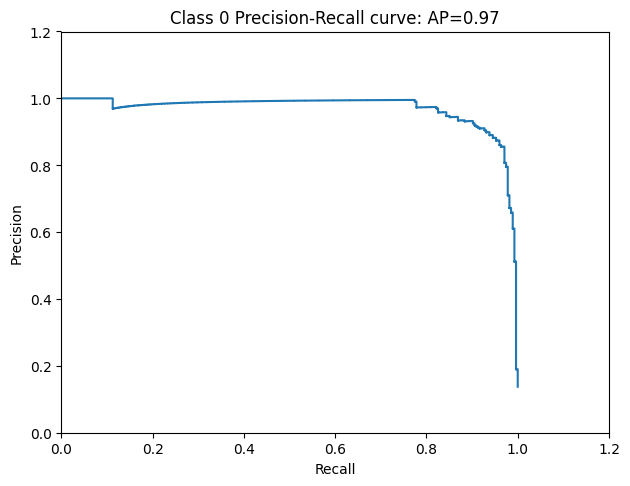

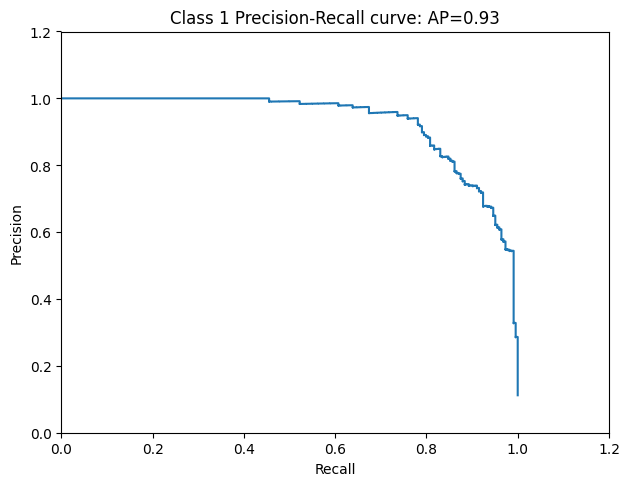

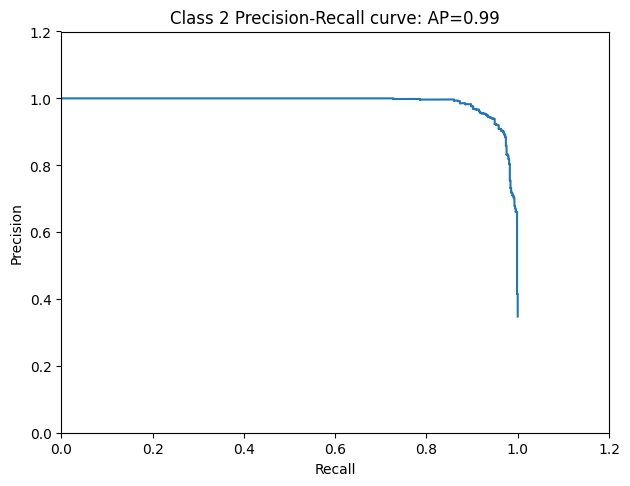

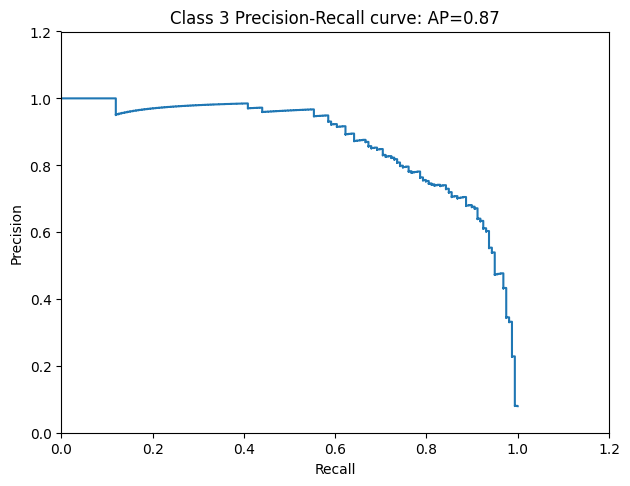

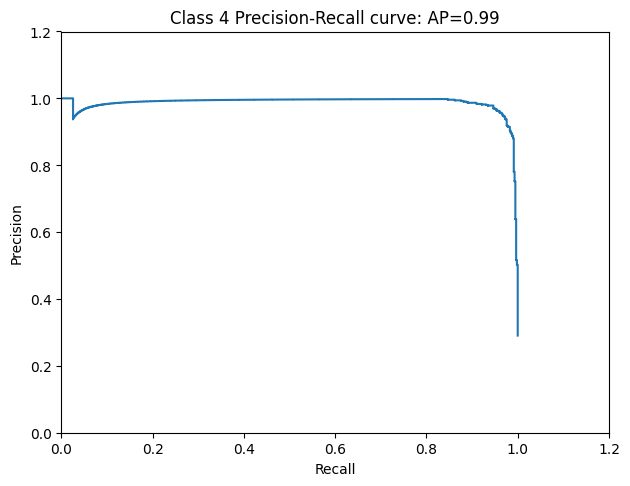

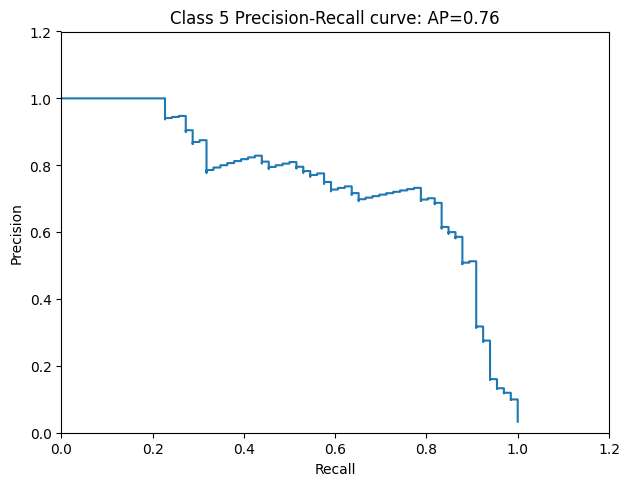

In [31]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score

# Ensure y_test is binarized for each class (one-vs-all approach)
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

precision = dict()
recall = dict()
average_precision = dict()

# Iterate over each class and compute precision-recall curve
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binarized[:, i], probabilities[:, i])
    average_precision[i] = average_precision_score(y_test_binarized[:, i], probabilities[:, i])

# Now plot the precision-recall curves
for i in range(n_classes):
    plt.figure()
    plt.step(recall[i], precision[i], where='post')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.2])
    plt.xlim([0.0, 1.2])
    plt.tight_layout
    plt.title(f'Class {i} Precision-Recall curve: AP={average_precision[i]:0.2f}')
    plt.show()


labels_dict = {0:'sad', 1:'happy', 2:'love', 3:'anger', 4:'fear', 5:'surprise'}

1. Class 0 - AP: 0.97: The model is excellent at identifying class 0. It can distinguish class 0 instances from instances of other classes with high precision across different recall levels.

2. Class 1 - AP: 0.93: The model is also performing well on class 1, though not as well as class 0. It may occasionally confuse class 1 with other classes or vice versa.

3. Class 2 - AP: 0.99: The model performs exceptionally well on class 2, similar to class 0. It is very good at classifying instances of class 2 correctly.

4. Class 3 - AP: 0.87: This score is lower compared to others, indicating that the model has more difficulty correctly identifying class 3, especially when it tries to increase its recall.

5. Class 4 - AP: 0.99: Like classes 0 and 2, class 4 is also identified with high precision and recall. The model is highly confident and accurate in distinguishing these instances.

6. Class 5 - AP: 0.76: This is the lowest AP score among all the classes, suggesting the model struggles the most with class 5. This could be due to class 5 instances being more similar to other classes, or it could be less represented in the training data.

In [32]:
unique_counts = train['emotion'].value_counts()
unique_counts

happy       5362
sad         4666
anger       2159
fear        1937
love        1304
surprise     572
Name: emotion, dtype: int64